In [1]:
import numpy as np
import pandas as pd
from glob import glob
from subprocess import check_output

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import r2_score

import pylab as plt
%matplotlib inline

## Get data

In [42]:
with open('pipeline_data/steps.dat', 'r') as handle:
    steps = handle.readline().strip().split()
    
ns = len(steps)

steps_c = [f'case{i}' for i in range(ns)]
steps_d = [f'death{i}' for i in range(ns)]
steps_ = steps_c + steps_d

In [43]:
data_fname = glob('pipeline_data/data_????-??-??.csv')[0]

# Get the two totals
last_date = data_fname.split('/')[-1][:-4].split('_')[-1]
print(f'last date = {last_date}')
steps_c = steps_c + [f'total_case']
steps_d = steps_d + [f'total_death']
steps_ = steps_c + steps_d

df = pd.read_csv(data_fname, dtype={'fips': str}).set_index('fips')
# tmp = df[[col for col in df.columns if col.startswith('case') or col.startswith('death')]]
# (tmp < 0).sum()

last date = 2020-12-21


In [44]:
per_population = 10000
for c in df.columns:
    # case and death per ten thousand people
    if 'case' in c or 'death' in c:
        df[c] = per_population * df[c] / df['population']

In [51]:
df['urban_risk'] = df['perc_urban_pop'] * (df['risk_flu'] - df['risk_flu'].min())

covariates = [
    # 'population', 
    'perc_65yrs', 
    'perc_minority', 
    'perc_black', 
    'perc_hispanic', 
    'perc_poverty', 
    'perc_urban_pop',
    'income',
    'risk_flu',
    'urban_risk'
]

df_z = df[steps_].copy()
for c in covariates:
    mean, std = df[c].mean(), df[c].std()
    df_z[c] = (df[c] - mean) / std
df_z.head()

case0     case1     case2     case3     case4     case5     case6  \
fips                                                                          
01001  2.147882  1.252931  1.073941  1.968892  1.968892  2.863842  8.054556   
01003  1.523065  1.612658  1.791842  2.015822  1.343881  1.523065  1.881434   
01005  1.215264  2.835615  3.240703  6.481406  3.645791  5.671231  9.722110   
01007  1.786193  4.018934  5.805126  3.572385  3.125837  1.786193  3.125837   
01009  2.075191  0.518798  1.556393  2.075191  1.037596  0.864663  0.345865   

           case7      case8      case9  ...  total_death  perc_65yrs  \
fips                                    ...                            
01001   8.591527  10.739408   8.591527  ...     7.875566   -0.794106   
01003   0.851125   0.537553   1.299085  ...     6.585018    0.257409   
01005  10.937373  19.039131  16.608604  ...    12.962813   -0.012923   
01007   3.125837   6.698223   2.232741  ...    18.755024   -0.647773   
01009   0.518798   2.248124   1.902258  ...     9.338360   -0.221003   

       perc_minority  perc_black  perc_hispanic  perc_poverty  perc_urban_pop  \
fips                                                                            
01001       0.512705    0.741329      -0.489703     -0.225017        0.535824   
01003      -0.180113   -0.042334      -0.365711     -0.883379        0.526204   
01005       2.192825    2.685016      -0.379632      2.589482       -0.291414   
01007       0.481481    0.821243      -0.504693      1.091708       -0.310652   
01009      -0.699751   -0.532156      -0.011632     -0.323771       -1.003223   

         income  risk_flu  urban_risk  
fips                                   
01001  0.480936  1.006875    0.666999  
01003  0.353735  1.296454    0.817850  
01005 -1.333023  0.420657   -0.240836  
01007 -0.483902  0.436170   -0.249735  
01009 -0.167862  0.617627   -0.724261  

[5 rows x 87 columns]

## Get GLM predictions

In [52]:
cov = '+'.join(covariates)
print(cov)

perc_65yrs+perc_minority+perc_black+perc_hispanic+perc_poverty+perc_urban_pop+income+risk_flu+urban_risk


### Case 

In [53]:
dfs_case = []
cors = []
for i in range(len(steps_c)):
    cur = steps_c[i]
    formula = f'{cur}~{cov}'

    model = smf.glm(
        formula=formula,
        data=df_z,
        family=sm.families.Poisson(sm.families.links.log())
    ).fit()
    print(f'{model.summary()}\n\n')
    
    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd * df['population'], 'grd': df_z[cur] * df['population']}, 
        index=df.index
    ).corr().loc['prd', 'grd']
    cors.append(cor)
    
    df_z[cur + '_glm'] = model.predict() * df['population'] / per_population
    
    dfs_case.append(pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  case0   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11196.
Date:                Thu, 24 Dec 2020   Deviance:                       15975.
Time:                        12:59:41   Pearson chi2:                 3.39e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9023      0.012     73.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  case6   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14395.
Date:                Thu, 24 Dec 2020   Deviance:                       22773.
Time:                        12:59:41   Pearson chi2:                 6.49e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.0417      0.012     90.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case12   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13787.
Date:                Thu, 24 Dec 2020   Deviance:                       19332.
Time:                        12:59:42   Pearson chi2:                 3.39e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.5131      0.009    168.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case18   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19719.
Date:                Thu, 24 Dec 2020   Deviance:                       28253.
Time:                        12:59:42   Pearson chi2:                 4.91e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.3183      0.006    394.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case24   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20938.
Date:                Thu, 24 Dec 2020   Deviance:                       30364.
Time:                        12:59:42   Pearson chi2:                 4.21e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.4245      0.005    446.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case29   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -29921.
Date:                Thu, 24 Dec 2020   Deviance:                       46149.
Time:                        12:59:42   Pearson chi2:                 5.80e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.0079      0.004    725.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case36   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -30669.
Date:                Thu, 24 Dec 2020   Deviance:                       44342.
Time:                        12:59:42   Pearson chi2:                 5.19e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.8582      0.003   1468.

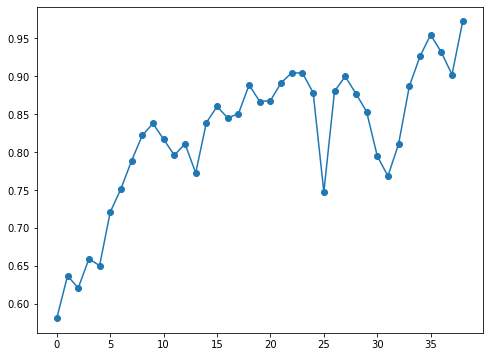

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(cors, marker='o')

### Death

In [55]:
dfs_death = []
cors = []
for i in range(len(steps_d)):
    cur = steps_d[i]
    formula = f'{cur}~{cov}'

    model = smf.glm(
        formula=formula,
        data=df_z,
        family=sm.families.Poisson(sm.families.links.log())
    ).fit()
    print(f'{model.summary()}\n\n')
    
    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd * df['population'], 'grd': df_z[cur] * df['population']}, 
        index=df.index).corr().loc['prd', 'grd']
    cors.append(cor)
    
    df_z[cur + '_glm'] = model.predict() * df['population'] / per_population
    
    dfs_death.append(pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 death0   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -867.45
Date:                Thu, 24 Dec 2020   Deviance:                       1032.1
Time:                        13:00:13   Pearson chi2:                 4.00e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.7296      0.076    -35.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 death6   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1222.9
Date:                Thu, 24 Dec 2020   Deviance:                       1412.5
Time:                        13:00:13   Pearson chi2:                 3.23e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.2057      0.060    -36.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death12   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -986.54
Date:                Thu, 24 Dec 2020   Deviance:                       1156.2
Time:                        13:00:13   Pearson chi2:                 3.55e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.5677      0.071    -36.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death18   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1656.3
Date:                Thu, 24 Dec 2020   Deviance:                       1840.6
Time:                        13:00:13   Pearson chi2:                 8.51e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.7386      0.046    -38.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death24   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1810.6
Date:                Thu, 24 Dec 2020   Deviance:                       2012.8
Time:                        13:00:14   Pearson chi2:                 6.91e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.5779      0.042    -37.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death30   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2574.9
Date:                Thu, 24 Dec 2020   Deviance:                       3091.6
Time:                        13:00:14   Pearson chi2:                 6.20e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.1203      0.034    -33.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death36   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4390.3
Date:                Thu, 24 Dec 2020   Deviance:                       4783.3
Time:                        13:00:14   Pearson chi2:                 6.92e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.1743      0.021     -8.

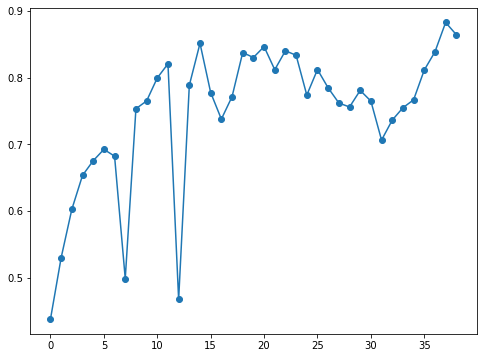

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(cors, marker='o')

In [32]:
# # cleanup and save
# existing_csv = glob('pipeline_data/data_????-??-??_glm.csv')

# if len(existing_csv) > 0:
#     for csv in existing_csv:
#         check_output(f'rm {csv}', shell=True)
        
# df_z.to_csv(data_fname[:-4] + '_glm.csv', float_format='%.2f')

## Validation

In [33]:
# cols = [col for col in df_z.columns if (col.startswith('case')) or (col.startswith('death'))]
# (df_z[cols] < 0).sum().sum()

0

## Get latex tables
Let us save them to the urisk folder directly for now